# Converted Data Censored CSV

In [21]:
import pandas as pd

df = pd.read_csv("csv/data_censored.csv")  # Load dataset
df.head()  # Check the first few rows

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [22]:
def define_estimand(data, estimand):
    if estimand == "PP":
        # Per-Protocol: Filter data where eligible == 1
        return data[data['eligible'] == 1]
    elif estimand == "ITT":
        # Intention-to-Treat: Use all data
        return data
    else:
        raise ValueError("Estimand must be 'PP' or 'ITT'")

# Example usage
trial_pp = define_estimand(df, "PP")
trial_itt = define_estimand(df, "ITT")

In [23]:
def prepare_data(data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    return data[[id_col, period_col, treatment_col, outcome_col, eligible_col]]

# Example usage
trial_pp_prepared = prepare_data(trial_pp, 'id', 'period', 'treatment', 'outcome', 'eligible')
trial_itt_prepared = prepare_data(trial_itt, 'id', 'period', 'treatment', 'outcome', 'eligible')

In [25]:
import statsmodels.api as sm

def calculate_weights(data, numerator_formula, denominator_formula, censor_event_col):
    # Fit numerator model
    numerator_model = sm.Logit(data[censor_event_col], sm.add_constant(data[numerator_formula])).fit(disp=0)
    numerator_probs = numerator_model.predict(sm.add_constant(data[numerator_formula]))
    
    # Fit denominator model
    denominator_model = sm.Logit(data[censor_event_col], sm.add_constant(data[denominator_formula])).fit(disp=0)
    denominator_probs = denominator_model.predict(sm.add_constant(data[denominator_formula]))
    
    # Calculate weights
    weights = (1 - numerator_probs) / (1 - denominator_probs)
    return weights

# Example usage for Per-Protocol
trial_pp.loc[:, 'weights'] = calculate_weights(trial_pp, numerator_formula, denominator_formula, 'censored')

# Example usage for Intention-to-Treat
trial_itt.loc[:, 'weights'] = calculate_weights(trial_itt, numerator_formula, denominator_formula, 'censored')

NameError: name 'numerator_formula' is not defined

In [5]:
X_switch = data_censored[["age", "x1", "x3"]]
y_switch = data_censored["treatment"]

X_censor = data_censored[["x2", "x1"]]
y_censor = data_censored["censored"]

In [6]:
scaler = StandardScaler()
X_switch_scaled = scaler.fit_transform(X_switch)
X_censor_scaled = scaler.fit_transform(X_censor)

In [7]:
switch_model = fit_logistic_model(X_switch_scaled, y_switch, os.path.join(trial_pp_dir, "switch_model.pkl"))
censor_model = fit_logistic_model(X_censor_scaled, y_censor, os.path.join(trial_pp_dir, "censor_model.pkl"))

In [8]:
switch_probs = switch_model.predict_proba(X_switch_scaled)[:, 1]
censor_probs = censor_model.predict_proba(X_censor_scaled)[:, 1]

In [9]:
data_censored["weight"] = 1 / (np.maximum(switch_probs, 1e-9))
data_censored["censor_weight"] = 1 / (np.maximum(censor_probs, 1e-9))

<Axes: xlabel='timeline'>

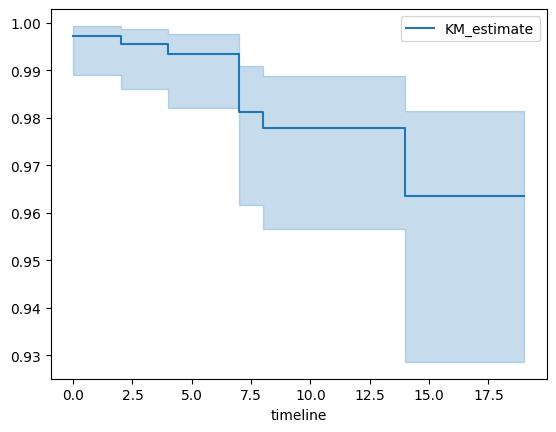

In [10]:
kf = KaplanMeierFitter()
kf.fit(data_censored["period"], event_observed=data_censored["outcome"])
kf.plot()

In [11]:
cph = CoxPHFitter()

In [20]:
X_survival = data_censored.drop(columns=["weight", "censor_weight"]).select_dtypes(include=[np.number]).dropna()
correlation_matrix = X_survival.corr().abs()
high_corr_vars = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > 0.9)]
data_censored = data_censored.drop(columns=high_corr_vars, errors='ignore')